# Author: Стурейко Игорь
## Project: Geekbrains.Algorithms
## Lesson 03 - Логистическая регрессия
## Date: 2020-08-31

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

## 1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [2]:
def calc_logloss(y_true: np.array, y_pred: np.array, bound=1e-5)->float:
    """
    Вычисление log-loss
    
    Parameters
    ==============
    y_true - вектор правильных ответов
    y_pred - вектор прогноза
    bound=1e-5 - граница отсечения
    """
    y_pred = y_pred.copy()
    y_pred = np.clip(y_pred, a_min=bound, a_max=1-bound)
    err = - np.mean(y * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))
    return err

## 2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [100]:
def eval_model(X: np.array, y: np.array, iterations=1000, alpha=1e-4, tol=1e-5):
    """
    Вычисление модели логистической регрессии
    Parameters:
    ------------
        X: np.array 
            Матрица признаков
        y: np.array
            Вектор ответов
        iterations=1000
            Количество итераций
        alpha=1e-4
            Скорость обучения
        tol=1e-5
            Выход из цикле, если ошибка меняется менее tol
    
    Returns:
    -----------
        weights:np.array
            Вектор весов модели
        errors: np.array
            Вектор ошибок по признакам
    """
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    errors, weights = [], []

    for n_iter in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        current_error = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        
        errors.append(current_error)
        weights.append(W)
        
        # проверяем выход по условию tol
        if n_iter > 2 and np.abs(current_error - errors[-2]) < tol:
            break
    errors = np.array(errors)
    weights = np.array(weights[-1])
    return weights, errors

In [101]:
def calc_std_feat(X: np.array)->np.array:
    """
    Scaling features using standardization
    The first sign is const = 1, so does not scale
    Parameters:
    ----------------
    X: np.array 
        Feature matrix
        
    Returns:
    ----------------
        X_trasformed: np.array
            Scaled feature matrix
    ================================================
    
    Масштабирование признаков методом стандартизации
    Первый признак const=1, поэтому не масштабируется
    
    Parameters:
    ----------------
    X: np.array 
        Матрица признаков
        
    Returns:
    ----------------
        X_trasformed: np.array
            Масштабированная матрица признаков    
    """
    X_transformed = X[1:,].copy()
    X_mean, X_std = X_transformed.mean(axis=1), X_transformed.std(axis=1)
    X_mean, X_std = X_mean.reshape(X_transformed.shape[0], 1), X_std.reshape(X_transformed.shape[0], 1)
    
    X_transformed = (X_transformed - X_mean) / X_std
    X_transformed = np.vstack((np.ones(X_transformed.shape[1]), X_transformed))
    return X_transformed

In [102]:
def sigmoid(z:float)->float:
    """
    Вычисление сигмоид преобразования
    
    Parameters:
    -----------
    z: float
        вещественное число
        
    Returns:
    -----------
        res:float = 1 / (1 + np.exp(-z))
    """
    res = 1 / (1 + np.exp(-z))
    return res

In [103]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 
               1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

1000it [00:27, 36.18it/s]


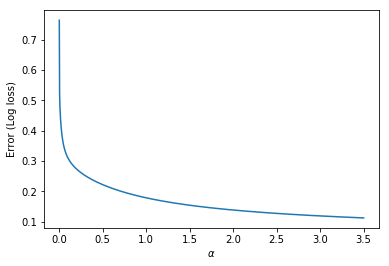

In [104]:
X_st = X.copy()
X_st = calc_std_feat(X)
steps = 1000
err = np.ones(steps)
a1 = 1e-5
a2 = 3.5
for step, alpha in tqdm(enumerate(np.linspace(a1, a2, steps))):
    W, err_ = eval_model(X_st, y, iterations=1000, alpha=alpha)
    err[step] = err_[-1]

s = np.linspace(a1, a2, steps)
plt.plot(s, err)
plt.xlabel(r'$\alpha$')
plt.ylabel('Error (Log loss)')
plt.show()

100it [00:27,  3.58it/s]


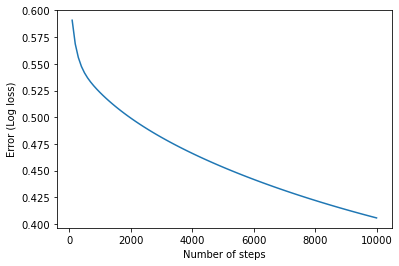

In [130]:
X_st = X.copy()
X_st = calc_std_feat(X)
steps = 100
err = np.ones(steps)
for step, iterations in tqdm(enumerate(np.linspace(1e2, 1e4, steps, dtype=int))):
    W, err_ = eval_model(X_st, y, iterations=iterations, alpha=1e-2)
    err[step] = err_[-1]

s = np.linspace(1e2, 1e4, steps)
plt.plot(s, err)
plt.xlabel('Number of steps')
plt.ylabel('Error (Log loss)')
plt.show()

## 3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [105]:
def calc_pred_proba(W:np.array, X:np.array)->np.array:
    """
    Функция вычисления предсказанной вероятности
    
    Parameters:
    ------------
    W:np.array
        вектор весов обученной модели
    X:np.array
        матрица признаков
    
    Returns:
    ------------
    y_pred:np.array
        вектор прогнозов
    """
    return sigmoid(W @ X)

In [106]:
y_pred_proba = calc_pred_proba(eval_model(X_st, y, iterations=1000, alpha=1e-2)[0], X)
y_pred_proba.shape

(10,)

## 4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [65]:
def calc_pred(W: np.array, X:np.array, bound:float=0.5)->np.array:
    """
    Функция вычисления предсказанной вероятности (лейблов признаков) на
    основе сигмоид преобразования по полученному вектору прогнозов
    
    Parameters:
    ------------
    W - вектор весов
    X - матрица признаков
    bound=0.5 - порог вероятности
    
    returns:
    y_pred - вектор предсказаний
    """
    y_pred = sigmoid(W @ X)
    y_pred = np.where(y_pred > bound, 1, 0)

    return y_pred

In [66]:
y_pred = calc_pred(eval_model(X_st, y, iterations=1000, alpha=1e-6)[0], X)
y_pred.shape

(10,)

## 5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [93]:
def accurency_score(y_true:np.array, y_pred:np.array)->float:
    """
    Вычисление метрики Acurancy
    
    Parameters:
    ------------
    y_true: np.array
        вектор правильных ответов
    y_pred: np.array
        вектор предсказаний
        
    Returns:
    ------------
    acur: float
        Значение метрики Acurancy
    """
    return (y_true == y_pred).sum() / y_true.shape[0]

In [94]:
print(accurency_score(y, y_pred))

0.5


In [87]:
def err_matrix(y_true:np.array, y_pred:np.array):
    """
    Вычисление матрицы ошибок
    
    Parameters:
    ------------
    y_true: np.array
        вектор правильных ответов
    y_pred: np.array
        вектор предсказаний
        
    Returns:
    ------------
    TP: int - TruePositive,
    FP: int - FalsePositive,
    TN: int - TrueNegative,
    FN: int - FalseNegative
        Значения матрицы ошибок
    
    """
    TP = y_true[(y_true - y_pred) == 0].sum().astype(int)
    FP = ((y_true - y_pred) == -1).sum().astype(int)
    TN = (y_true[(y_true - y_pred) == 0]==0).sum().astype(int)
    FN = ((y_true - y_pred) == 1).sum().astype(int)
    return TP, FP, TN, FN

In [83]:
print(err_matrix(y, y_pred))

(5, 5, 0, 0)


In [89]:
def precision_score(y_true:np.array, y_pred:np.array)->float:
    """
    Вычсление метрики precision
    конверсия = TP / (TP + FP)
    
    Parameters:
    ------------
    y_true: np.array
        вектор правильных ответов
    y_pred: np.array
        вектор предсказаний
        
    Returns:
    ------------
    precision: float
        значение метрики precision
    """
    TP, FP, _, _ = err_matrix(y_true, y_pred)
    return TP / (TP + FP)

In [90]:
precision_score(y, y_pred)

0.5

In [95]:
def recall_score(y_true:np.array, y_pred:np.array)->float:
    """
    Вычисление метрики recall = TP / (TP + FN)
    
    Parameters:
    ------------
    y_true: np.array
        вектор правильных ответов
    y_pred: np.array
        вектор предсказаний
        
    Returns:
    ------------
    recall: float
        значение метрики precision
    """
    TP, _, _, FN = err_matrix(y_true, y_pred)
    return TP / (TP + FN)

In [96]:
recall_score(y, y_pred)

1.0

In [97]:
def f1_score(y_true:np.array, y_pred:np.array)->float:
    """
    Вычисление метрики F1:
    
    Parameters:
    ------------
    y_true: np.array
        вектор правильных ответов
    y_pred: np.array
        вектор предсказаний
        
    Returns:
    ------------
    F1: float
        значение метрики F1
    """
    
    return round(2 * precision(y_true, y_pred) * recall(y_true, y_pred) / (precision(y_true, y_pred) + recall(y_true, y_pred)), 4)

In [98]:
f1_score(y, y_pred)

0.6667

## 6. Могла ли модель переобучиться? Почему?

В примере использована маленькая выборка - модель могла переобучится.

## 7*. Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [ ]:
def eval_model_l2(X, y, iterations=1000, alpha=1e-4, lambda_):
    """
    Функция модели логистической регрессии
    
    Params:
    =======
    X - матрица признаков
    y - вектор ответов
    iterations=1000 - количество итераций
    alpha = 1e-4 - скорость обучения
    lambda_ - коэффициент регуляризации
    """
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    err = np.ones(iterations)
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err[i-1] = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T)+ 2 * lambda_ * W)
    if i % (iterations / 10) == 0:
        print(i, W, err)
    return W, err

In [107]:
def eval_model_regularization(X:np.array,
                              y:np.array,
                              iterations: int = 1000,
                              alpha: float = 1e-2,
                              tol: float = 1e-5,
                              c1: float = 0.,
                              c2: float = 0.):
    """
    Функция модели логистической регрессии c L1 и L2 регуляризацией
    
    Params:
    =======
    X:np.array
        Матрица признаков
    y:np.array
        Вектор ответов
    iterations: int = 1000
        Количество итераций
    alpha: float = 1e-2
        Скорость обучения
    tol: float
        Порог точности расчета ошибки
    c1: float
        Коэффициент L1 регуляризации
    c2: float
        Коэффициент L2 регуляризации
    
     Returns:
    -----------
        weights:np.array
            Вектор весов модели
        errors: np.array
            Вектор ошибок по признакам
    """
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    errors, weights = [], []
    
    for n_iter in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        current_error = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T)) + 2*c2*W + 0.5*c1*W/np.abs(W)
        
        errors.append(current_error)
        weights.append(W)
        
        # проверяем выход по условию tol
        if n_iter > 2 and np.abs(current_error - errors[-2]) < tol:
            break
    errors = np.array(errors)
    weights = np.array(weights[-1])
    return weights, errors